### Install and Import packages

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import initializers

from tensorflow.keras.models import load_model

### Data preparation

Az adatainkat a yfinance csomag segítségével töltöttük le. Mindkét model esetében a GOOG adathalmaz Close attribútumát használtuk fel 2004-08-19 kezdődátummal.

In [ ]:
# Download Google stock data
data = yf.download("GOOG", start="2004-08-19", end="2025-04-26")

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478922,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567420,2.757554,306396159
2004-08-25,2.627658,2.677238,2.575105,2.601877,184645512
...,...,...,...,...,...
2025-04-21,149.860001,151.059998,148.399994,150.964996,16147800
2025-04-22,153.899994,154.610001,150.869995,151.070007,15910300


In [ ]:
# Reset the index to make 'Date' a regular column
data_modified = data.reset_index()

# Select the desired columns
data_modified = data_modified[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
data_modified

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2004-08-19,2.487352,2.579567,2.378775,2.478922,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
3,2004-08-24,2.599647,2.766478,2.567420,2.757554,306396159
4,2004-08-25,2.627658,2.677238,2.575105,2.601877,184645512
...,...,...,...,...,...,...
5200,2025-04-21,149.860001,151.059998,148.399994,150.964996,16147800
5201,2025-04-22,153.899994,154.610001,150.869995,151.070007,15910300
5202,2025-04-23,157.720001,160.020004,156.350006,157.910004,18575700


In [ ]:
data = data[["Close"]]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### Hyperparameters

A model tanítása során több hiperparamétert is kipóbáltunk, már az algoritmikus hiperparaméter optimalizálás előtt. Például kipróbáltuk a tanítást változó learning_rate-tel, illetve próbáltunk hatni az LSTM forget_gate-jére is.

Kipróbáltuk a több (3) napos előrejelzést is.

In [ ]:
# HYPERPARAMETERS

# Define a learning rate schedule
def lr_schedule(epoch):
    """
    Returns a learning rate based on the current epoch.
    """
    initial_lr = 0.01  # Initial learning rate
    decay_rate = 0.75    # Decay rate per epoch
    decay_steps = 10    # Number of epochs to decay after

    # Calculate the new learning rate
    new_lr = initial_lr * decay_rate**(epoch // decay_steps)

    return new_lr

# Create an Adam optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.01)

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

num_layers = 5
output_len = 1  # Predict output_len days ahead
past_window = 10
units = 160
epochs = 500
batch_size = 32
val_split = 0.05
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True,
                               verbose=1,
                               start_from_epoch=20
                               )

bias_initializer=initializers.Constant(1.0)

### Train-Test-Val

Az adat vágásánál eredetileg 80%-ot szerettünk volna a train adatnak szánni, azonban az adat grafikonján megfigyelhető, hogy éppen ezt követően történik jelentősebb változás a grafikon jellegében. Fontos volt a vágás eldöntésénél az, hogy egyrész összefüggő train adathalmazunk legyen, hogy ami adat van, azt használjuk fel, másrészt az, hogy a változás utáni adatokból is eleget lásson a model.

A tanítás és tesztelés tisztasága érdekében hagytunk ki adatokat a train és validációs illetve a validációs és teszt adathalmazok között. Mivel a változás az adatban eléggé a vége felé volt, ezért csak 30 napot.

A lenti ábrán látható az adatvágás (pirossal az adathalmaz vége, zölddel az adathalmaz eleje látszik)

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Split into train + (val+test)
train_data, temp_data = train_test_split(data, test_size=val_split, random_state=42)
train_data_len = len(train_data)

# 2. Split (val+test) into val + test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
val_data_len = len(val_data)
test_data_len = len(test_data)

In [ ]:
from sklearn.model_selection import train_test_split

n=30

# 1. Split into train + (val+test)
train_data, temp_data = train_test_split(data, test_size=val_split, random_state=42)
train_data_len = len(train_data)

# 2. Split (val+test) into val + test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
val_data_len = len(val_data)
test_data_len = len(test_data)


# Calculate the break indices
val_start_index = train_data_len + n
val_end_index = val_start_index + val_data_len
test_start_index = val_end_index + n


# Create train, validation, and test sets with breaks
train_data = data[:train_data_len]
val_data = data[val_start_index:val_end_index]
test_data = data[test_start_index:]

In [ ]:
# Select data from scaled_data based on the new indices
train_data = scaled_data[0:train_data_len, :]
val_data = scaled_data[val_start_index : val_end_index, :]
test_data = scaled_data[test_start_index:, :]

In [ ]:
# Create train data
x_train = []
y_train = []

for i in range(past_window , len(train_data)):
    x_train.append(train_data[i-past_window :i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create validation data
x_val = []
y_val = []

for i in range(past_window, len(val_data)):
    x_val.append(val_data[i-past_window:i, 0])
    y_val.append(val_data[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Create test data
x_test = []
y_test = []

for i in range(past_window, len(test_data)):
    x_test.append(test_data[i-past_window:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

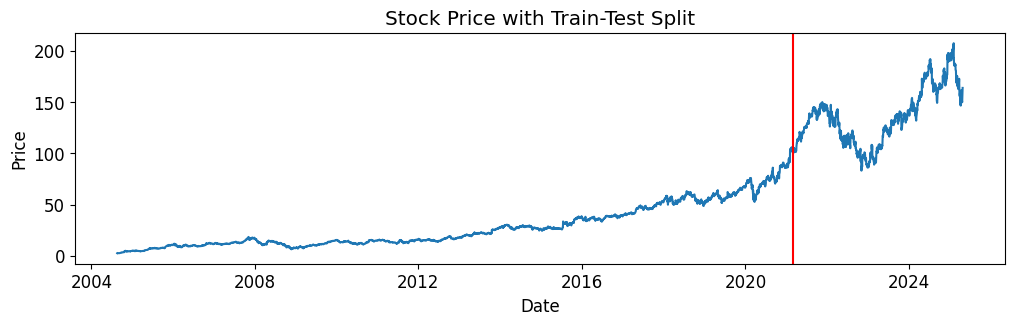

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(data['Close'])
plt.axvline(x=data_modified['Date'][len(data)*0.8],
            color='r',
            linestyle='-')
plt.title('Stock Price with Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

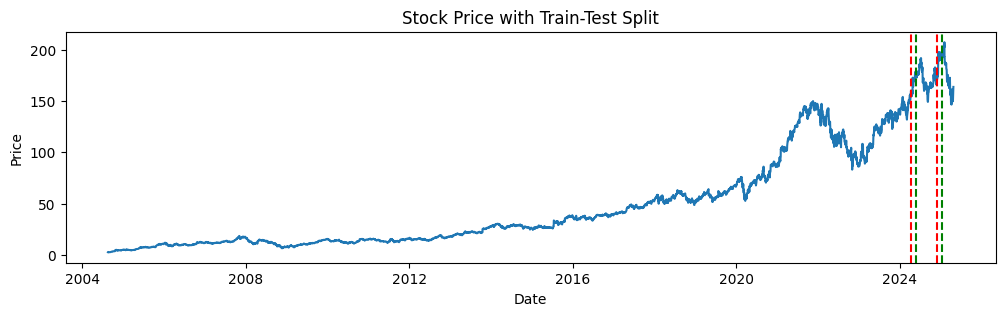

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(data['Close'])  # Replace 'Close' with the column name you want to plot
plt.axvline(x=data_modified['Date'][train_data_len],
            color='r',
            linestyle='--')  # Add vertical line
plt.axvline(x=data_modified['Date'][val_start_index],
            color='g',
            linestyle='--')  # Add vertical line
plt.axvline(x=data_modified['Date'][val_end_index],
            color='r',
            linestyle='--')  # Add vertical line
plt.axvline(x=data_modified['Date'][test_start_index],
            color='g',
            linestyle='--')  # Add vertical line
plt.title('Stock Price with Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

 ### Model

Modellnek az LSTM-et választottuk, mivel koránni tapasztalataink alapján ez egy jó választás idósoros problémák kezelésére. Azonban az eredményeink nem lettek annyira jók, mint azt vártuk. Ha ez egy nagyobb lélegzetvételű projekt lenne, akkor követkető lépésként kipróbálnánk az LSTM alapú encoder-decoder struktúrájú modellt illetve egy transformert is. Összehasonlításképpen kipróbálhatnénk RNN ill GRU modelleket is.

In [ ]:
# Define the LSTM model
def create_lstm_model(num_layers,
                      input_size=10,
                      units=50,
                      output_len=1,
                      optimizer='adam',
                      loss='mean_squared_error',
                      bias_initializer=initializers.Constant(1.0)):

    model = Sequential()

    # Add the first LSTM layer
    model.add(LSTM(units=input_size,
                   bias_initializer=bias_initializer,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], 1)))

    # Add additional LSTM layers if specified
    for _ in range(num_layers - 1):
        model.add(LSTM(units=units,
                       bias_initializer=bias_initializer,
                       return_sequences=True))

    # Add a final LSTM layer without return_sequences
    model.add(LSTM(units=units,
                   bias_initializer=bias_initializer))

    # Add a dense output layer for prediction
    model.add(Dense(output_len))  # Output output_len days prediction
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [ ]:
model = create_lstm_model(num_layers=num_layers,
                          input_size=past_window,
                          units=units,
                          output_len=output_len,
                          optimizer=optimizer,
                          loss='mean_squared_error')

# Train the model and store the history
if output_len > 1:
    history = model.fit(x_train[:-output_len+1],
                        np.array([y_train[i:i+output_len] for i in range(len(y_train) - output_len + 1)]),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, lr_scheduler],
                        validation_data=(x_val[:-output_len+1],
                                        np.array([y_val[i:i+output_len] for i in range(len(y_val) - output_len + 1)])))
else:

    history = model.fit(x_train,
                        np.array([y_train[i:i+output_len] for i in range(len(y_train))]),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, lr_scheduler],
                        validation_data=(x_val,
                                        np.array([y_val[i:i+output_len] for i in range(len(y_val))])))

Epoch 1/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - loss: 3.0751 - val_loss: 0.3555 - learning_rate: 0.0100
Epoch 2/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - loss: 0.0408 - val_loss: 0.3569 - learning_rate: 0.0100
Epoch 3/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 0.0405 - val_loss: 0.4170 - learning_rate: 0.0100
Epoch 4/500
 66/155 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.0414

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save('my_model_1104.h5')

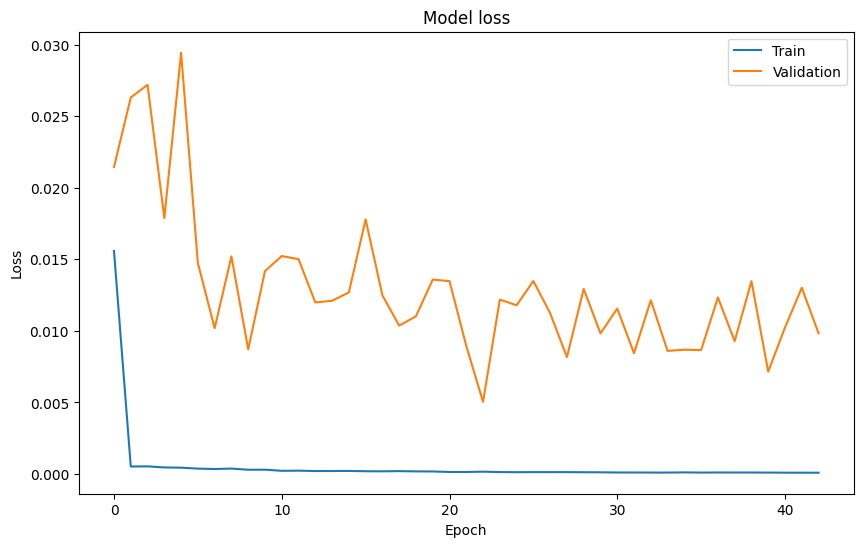

In [ ]:
# Plot training & validation loss values
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

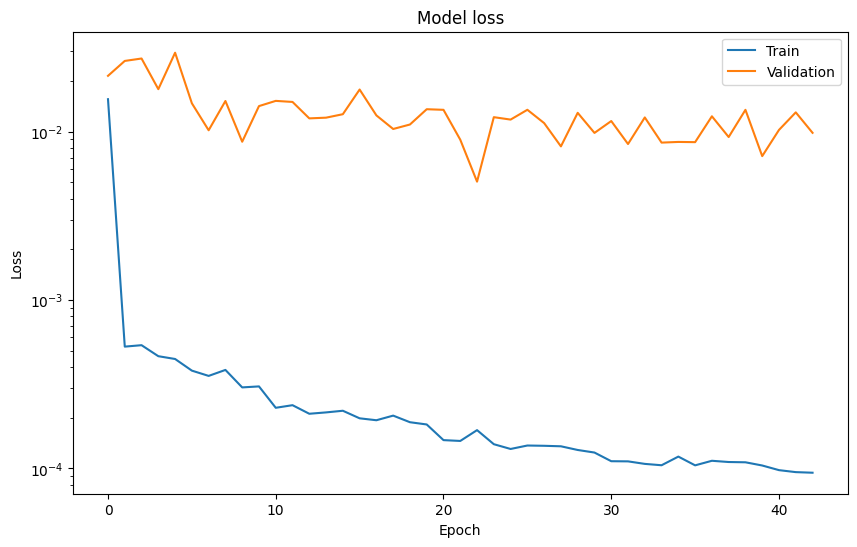

In [ ]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.show()

### Hyperparameter tuning

A hiperparaméter optimalizálásra több lépésben került sor, és az eredmények alapján választottuk meg a következő lépés lehetséges hiperparamétereit.

A lehetséges paraméterkombinációkból 15-öt próbáltunk ki lépésenként (összesen 45-öt), mindegyiket kétszer, 5 epochon. (Korábban voltak kezdetlegesebb próbálkozások 10 epoch-kal és 3-szor, de ez túlságosan hosszú idő volt). A t9bbszöri futtatásra a robosztusság miatt volt szükség.

A tuning végén elmentettük a próbálkozásokat egy csv fájlba, illetve a lépés legjobb paraméter-kombinációjával tanítottunk is modelt. Végül a 45 közül a legjobb kombinációval is tanítottunk egyet. És ezeket a modelleket elmentettük. A fájl neve a tanítás indításának idejére utal.

Fontos megjegyeztni, hogy mivel ezek csak 5 epochig futottak, előfordulhat (és elő is fordult), hogy egy jobbnak értékelt paraméterkombináció rosszabb modelt eredményez.

In [ ]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Tune bias initializer value
    bias_value = hp.Choice('bias_value', values=[1.0, 1.2])
    bias_initializer = initializers.Constant(bias_value)

    # Tune the number of LSTM layers
    num_layers = hp.Int('num_layers', 4, 4)

    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=True if i < num_layers - 1 else False,
            input_shape=(x_train.shape[1], 1) if i == 0 else None,
            bias_initializer=bias_initializer
        ))

    # Output layer
    model.add(Dense(output_len))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 7e-5, 5e-5])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Custom tuner class to tune batch size
class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        batch_size = hp.Int('batch_size', min_value=4, max_value=16, step=4)
        kwargs['batch_size'] = batch_size

        history = super().run_trial(trial, *args, **kwargs)

        return history

# Initialize the tuner
tuner = MyTuner(
    build_model,
    objective='val_loss',
    max_trials=15,              # Number of different combinations to try
    executions_per_trial=2,    # Number of runs per trial for robustness
    directory='my_dir',
    project_name='stock_prediction'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=20
)

if output_len > 1:
    x_input = x_train[:-output_len+1]
    y_input = np.array([y_train[i:i+output_len] for i in range(len(y_train) - output_len + 1)])
    x_val_input = x_val[:-output_len+1]
    y_val_input = np.array([y_val[i:i+output_len] for i in range(len(y_val) - output_len + 1)])
else:
    x_input = x_train
    y_input = np.array([y_train[i:i+output_len] for i in range(len(y_train))])
    x_val_input = x_val
    y_val_input = np.array([y_val[i:i+output_len] for i in range(len(y_val))])


In [ ]:
# Then pass to tuner
tuner.search(
    x_input,
    y_input,
    epochs=5,
    validation_data=(x_val_input, y_val_input),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
best_batch_size = best_hps.get('batch_size')

In [ ]:
# Collect all trials
trials = tuner.oracle.trials.values()

# Extract relevant information
trial_data = []
for trial in trials:
    data = trial.hyperparameters.values.copy()  # hyperparameter values
    data['val_loss'] = trial.score               # validation loss
    trial_data.append(data)

# Convert to DataFrame
results_df = pd.DataFrame(trial_data)

# Save to CSV
results_df.to_csv('tuning_results3.csv', index=False)

print("Tuning results saved to 'tuning_results3.csv'")


Tuning results saved to 'tuning_results3.csv'


In [ ]:
history = model.fit(
    x_input,
    y_input,
    epochs=500,
    batch_size=best_batch_size,
    validation_data=(x_val_input, y_val_input),
    callbacks=[early_stopping]
)


Epoch 1/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 0.0382 - val_loss: 0.0120
Epoch 2/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 4.0309e-04 - val_loss: 0.0075
Epoch 3/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 3.7499e-04 - val_loss: 0.0075
Epoch 4/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 3.3193e-04 - val_loss: 0.0077
Epoch 5/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 3.7499e-04 - val_loss: 0.0023
Epoch 6/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 4.1066e-04 - val_loss: 0.0082
Epoch 7/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 2.7301e-04 - val_loss: 0.0149
Epoch 8/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 3.9767e-04 - val_loss: 0.0026
Epoch 9/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 3.0498e-04 - val_loss: 0.0019
Epoch 10/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 3.1470e-04 - val_loss: 0.0047
Epoch 11/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/

In [ ]:
# Save the model
model.save('model_tuning_0110.h5')

### Hyperparamer chosing

In [ ]:
file1 = 'tuning_results.csv'
file2 = 'tuning_results2.csv'
file3 = 'tuning_results3.csv'

try:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)

    # Concatenate the DataFrames
    combined_df = pd.concat([df1, df2, df3], ignore_index=True)

    # Now combined_df contains the data from all three CSV files
    print(combined_df.head())

except FileNotFoundError:
    print(f"One or more of the files ({file1}, {file2}, {file3}) not found.")
except pd.errors.EmptyDataError:
    print(f"One or more of the files ({file1}, {file2}, {file3}) are empty.")
except Exception as e:
    print(f"An error occurred: {e}")


   bias_value  num_layers  units_0  units_1  units_2  learning_rate  \
0         2.0           8      256       64      160         0.0100   
1         1.0           4       96      224      160         0.0001   
2         1.0           7      192       32      160         0.0100   
3         0.5           8      192       32      224         0.0010   
4         0.5           8      128      160      192         0.0001   

   batch_size  units_3  units_4  units_5  units_6  units_7  val_loss  
0          16     32.0     32.0     32.0     32.0     32.0  0.288536  
1          16    192.0    256.0    160.0     32.0    256.0  0.004232  
2          16     32.0    160.0     96.0     32.0    160.0  0.257166  
3          64    224.0    256.0    128.0     64.0    128.0  0.304230  
4         112    224.0    128.0    224.0    128.0    160.0  0.009995  


In [ ]:
# Sort the combined DataFrame by 'val_loss'
combined_df_sorted = combined_df.sort_values(by='val_loss')

# Print the sorted DataFrame
combined_df_sorted.head(5)

,bias_value,num_layers,units_0,units_1,units_2,learning_rate,batch_size,units_3,units_4,units_5,units_6,units_7,val_loss
30,1.0,4,64,96,160,0.00007,4,64.0,NaN,NaN,NaN,NaN,0.002635
36,1.0,4,224,224,192,0.00005,4,160.0,NaN,NaN,NaN,NaN,0.002830
1,1.0,4,96,224,160,0.00010,16,192.0,256.0,160.0,32.0,256.0,0.004232
24,0.7,3,192,256,32,0.00005,48,224.0,160.0,NaN,NaN,NaN,0.004631
38,1.2,4,160,128,224,0.00007,8,64.0,NaN,NaN,NaN,NaN,0.004671


In [ ]:
combined_df_sorted.to_csv("tuning_full.csv")

In [ ]:
import keras_tuner as kt

# Load best hyperparameters from DataFrame
row = combined_df_sorted.iloc[0]

# Rebuild a HyperParameters object properly
best_hps = kt.HyperParameters()

# Set each hyperparameter as expected in your build_model function
best_hps.Choice('bias_value', values=[0.5, 1.0, 2.0, 2.5], default=row['bias_value'])
best_hps.Int('num_layers', min_value=3, max_value=8, default=int(row['num_layers']))
best_hps.Choice('learning_rate', values=[1e-2, 1e-3, 7e-5], default=row['learning_rate'])

# You also need to restore layer-wise units like units_0, units_1, ..., depending on num_layers
for i in range(int(row['num_layers'])):
    best_hps.Int(f'units_{i}', min_value=32, max_value=256, step=32, default=int(row[f'units_{i}']))

# Same for batch size
best_hps.Int('batch_size', min_value=16, max_value=128, step=16, default=int(row['batch_size']))

# Now build and train the model
model = tuner.hypermodel.build(best_hps)

# Train
history = model.fit(
    x_input,
    y_input,
    epochs=500,
    batch_size=int(row['batch_size']),
    validation_data=(x_val_input, y_val_input),
    callbacks=[early_stopping]
)

# Save
model.save('final_tuned_model.h5')
print("✅ Model trained and saved as 'final_tuned_model.h5'")


Epoch 1/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0711 - val_loss: 0.0121
Epoch 2/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.4682e-04 - val_loss: 0.0105
Epoch 3/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.2162e-04 - val_loss: 0.0068
Epoch 4/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 3.4269e-04 - val_loss: 0.0073
Epoch 5/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.6201e-04 - val_loss: 0.0037
Epoch 6/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.7008e-04 - val_loss: 0.0045
Epoch 7/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 3.3853e-04 - val_loss: 0.0050
Epoch 8/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 3.9933e-04 - val_loss: 0.0043
Epoch 9/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 2.7417e-04 - val_loss: 0.0032
Epoch 10/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 3.6248e-04 - val_loss: 0.0062
Epoch 11/500
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - los

✅ Model trained and saved as 'final_tuned_model.h5'


### Load model and evaluate

Ez a szekció volt arra, hogy betöltsük a választott betanult modelt és alap kiértékelést végezzünk rajta. Arra szolgált, hogy legyen valami képünk arról, hogy az aktuális model jobb-e, mint az eddigi legjobb, vagy egyáltalán jó-e annyira, hogy megtartsuk. A valódi, részletes kiértékelés nem itt történt.

Néhány ábrát is generáltunk, a szemléletesebb kiértékelés érdekében.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.5549e-04 
Model Loss: 0.0007732854573987424


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step


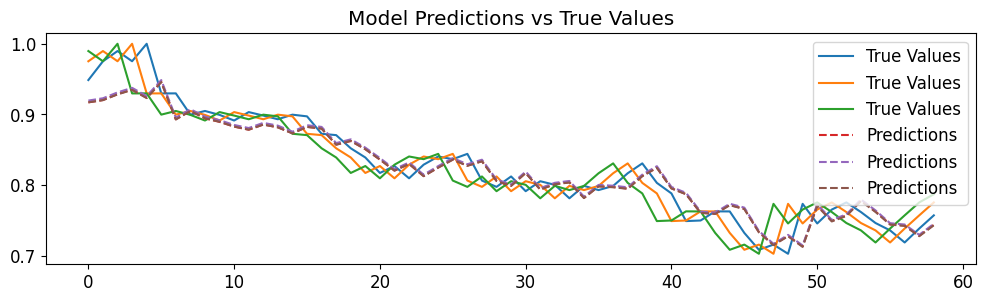

In [ ]:
# Load the saved model
model = load_model('model_tuning_0001.h5')

output_len = 3
# Prepare the correct shape for the test data based on output_len
if output_len > 1:
    x_test_input = x_test[:-output_len+1]
    y_test_input = np.array([y_test[i:i+output_len] for i in range(len(y_test) - output_len + 1)])
else:
    x_test_input = x_test
    y_test_input = y_test

# Evaluate the model
loss = model.evaluate(x_test_input, y_test_input)
print(f"Model Loss: {loss}")

# Make predictions
predictions = model.predict(x_test_input)

# If you want to visualize predictions vs true values
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(y_test_input)), y_test_input, label='True Values')
plt.plot(np.arange(len(predictions)), predictions, label='Predictions', linestyle='--')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.show()


In [ ]:
# Reshape predictions to 2D
predictions_2d = predictions.reshape(-1, output_len)
y_test_2d = np.array([y_test[i:i+output_len] for i in range(len(y_test) - output_len + 1)])

predictions_rev = scaler.inverse_transform(predictions_2d)
y_test_rev = scaler.inverse_transform(y_test_2d)

In [ ]:
# Calculate RMSE for each column (prediction day)
rmse_values = []
for i in range(output_len):
    rmse = np.sqrt(np.mean((predictions_rev[:, i] - y_test_rev[:, i])**2))
    rmse_values.append(rmse)

print("RMSE values for each prediction day:")
for i, rmse in enumerate(rmse_values):
    print(f"Day {i+1}: {rmse}")


RMSE values for each prediction day:
Day 1: 5.017667382496895
Day 2: 5.480271259463835
Day 3: 6.502022850993919


RMSE values for each prediction day TEST (1759):
- Day 1: 21.197682209099955
- Day 2: 22.267520141702892
- Day 3: 23.8449297815814

RMSE values for each prediction day TEST (2230):
- Day 1: 18.324466109453713
- Day 2: 19.51322851279943
- Day 3: 18.338601422345086

1-day, TEST tuning 1217: RMSE values for each prediction day:
- Day 1: 4.644026953369767

1-day TEST, tuning 2234: RMSE values for each prediction day:
- Day 1: 5.199929843336216

1-day TEST, tuning final: RMSE values for each prediction day:
- Day 1: 4.942576755762257

In [ ]:
# Create a DataFrame for the results
results_df = pd.DataFrame()


# Add the dates to the results dataframe
results_df['Date'] = data_modified['Date'][test_start_index+past_window:len(data) - output_len + 1]

# Assuming predictions are for the next 3 days (adjust the range if needed)
for i in range(output_len):
    results_df[f'Prediction_Day_{i+1}'] = predictions_rev[:, i]

results_df['Truth'] = y_test_rev[:,0]  # Assuming you want the truth for the first day of the prediction horizon

#Add predictions from yesterday, two days ago, three days ago
for i in range(1,1+output_len):
    results_df[f'Prediction_{i}_Days_Ago'] = results_df[f'Prediction_Day_{i}'].shift(i)

# Assuming predictions are for the next 3 days (adjust the range if needed)
for i in range(output_len):
    results_df.drop(columns=[f'Prediction_Day_{i+1}'], inplace=True)

# Save to CSV
results_df.to_csv('predictions_with_lags_test.csv', index=False)


In [ ]:
results_df = pd.read_csv('predictions_with_lags_test.csv')
results_df.head(10)

,Date,Truth,Prediction_1_Days_Ago,Prediction_2_Days_Ago,Prediction_3_Days_Ago
0,2025-01-29,196.955612,NaN,NaN,NaN
1,2025-01-30,202.399414,190.48454,NaN,NaN
2,2025-01-31,205.366043,191.16226,191.00370,NaN
3,2025-02-03,202.409393,192.86696,191.67004,190.49796
4,2025-02-04,207.473633,194.19453,193.36910,191.13167
5,2025-02-05,193.080032,191.82271,194.69534,192.79436
6,2025-02-06,193.090012,196.42050,192.31218,194.09820
7,2025-02-07,186.927032,185.58092,196.93999,191.72656
8,2025-02-10,187.985825,187.97408,186.05050,196.34738
9,2025-02-11,186.857132,185.84620,188.49374,185.51650


   Prediction_1_Days_Ago  Prediction_2_Days_Ago  Prediction_3_Days_Ago
0                    NaN                    NaN                    NaN
1              190.48454                    NaN                    NaN
2              191.16226              191.00370                    NaN
3              192.86696              191.67004              190.49796
4              194.19453              193.36910              191.13167


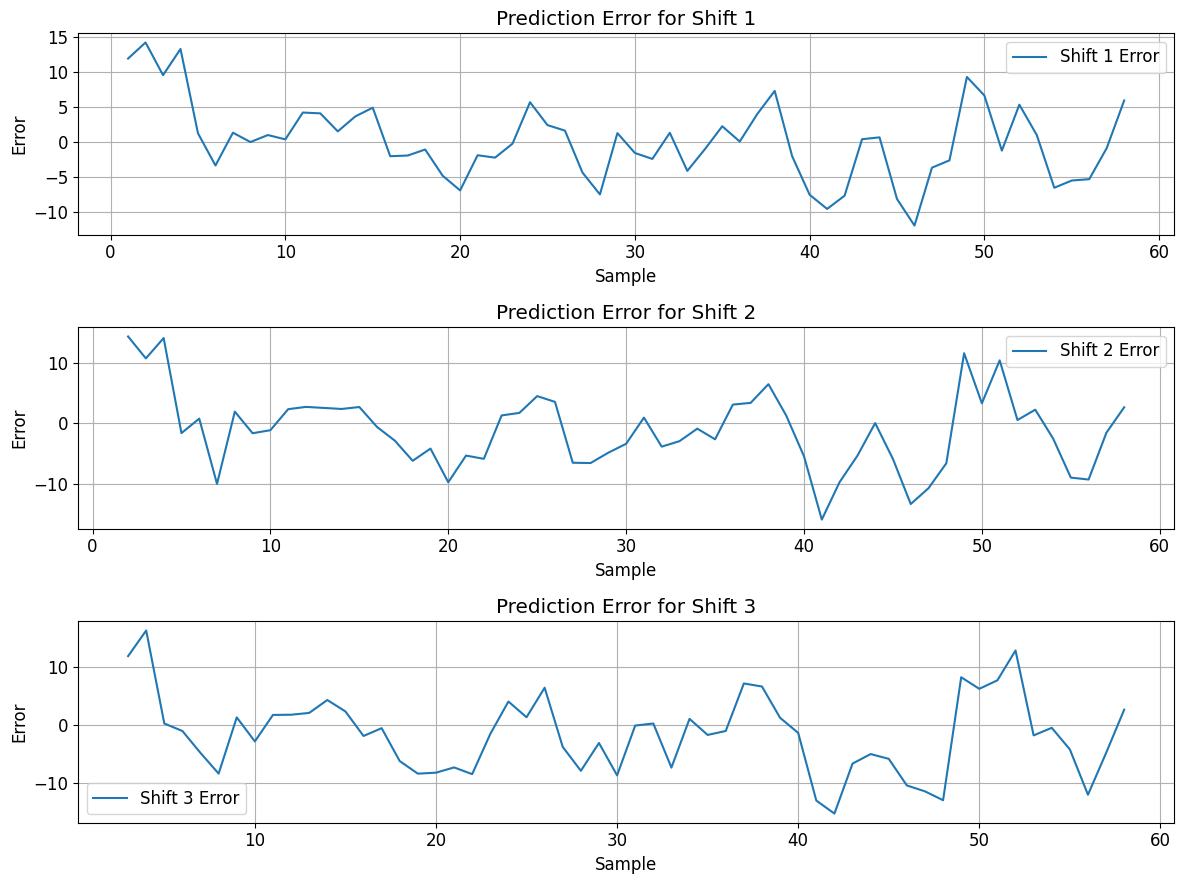

In [ ]:
pred_df = results_df.drop(['Date'], axis=1, errors='ignore').copy()

# Select prediction columns (all except 'Truth' and 'Date')
pred_cols = [col for col in pred_df.columns if col not in ['Truth', 'Date']]
pred_df = pred_df[pred_cols]  # Subset DataFrame

print(pred_df.head())

# Calculate the errors for each day
errors = results_df['Truth'].values[:, None] - pred_df.values # Convert to NumPy arrays for subtraction

# errors = results_df['Truth'] - pred_df  # Original line causing the error

# Plot the errors for each shift/column
num_shifts = errors.shape[1]  # Number of shifts/columns

plt.figure(figsize=(12, 3 * num_shifts))

for i in range(num_shifts):
    plt.subplot(num_shifts, 1, i + 1)
    plt.plot(errors[:, i], label=f'Shift {i+1} Error')
    plt.xlabel('Sample')
    plt.ylabel('Error')
    plt.title(f'Prediction Error for Shift {i+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

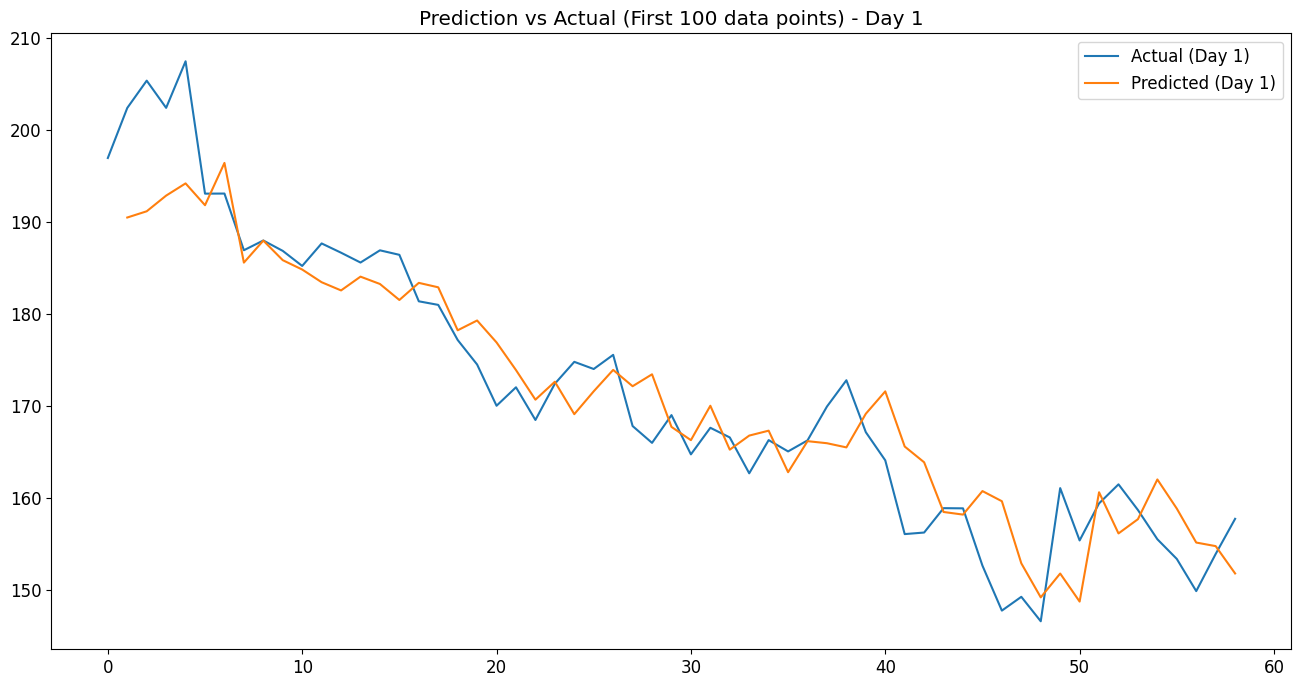

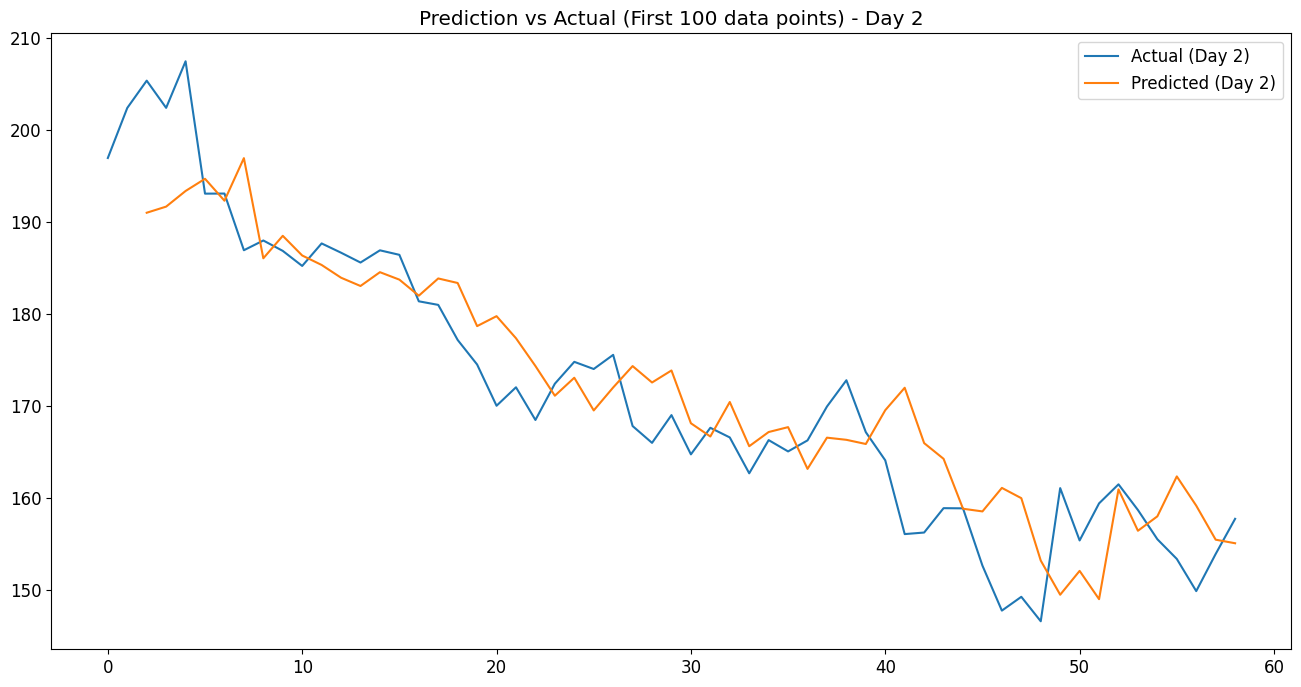

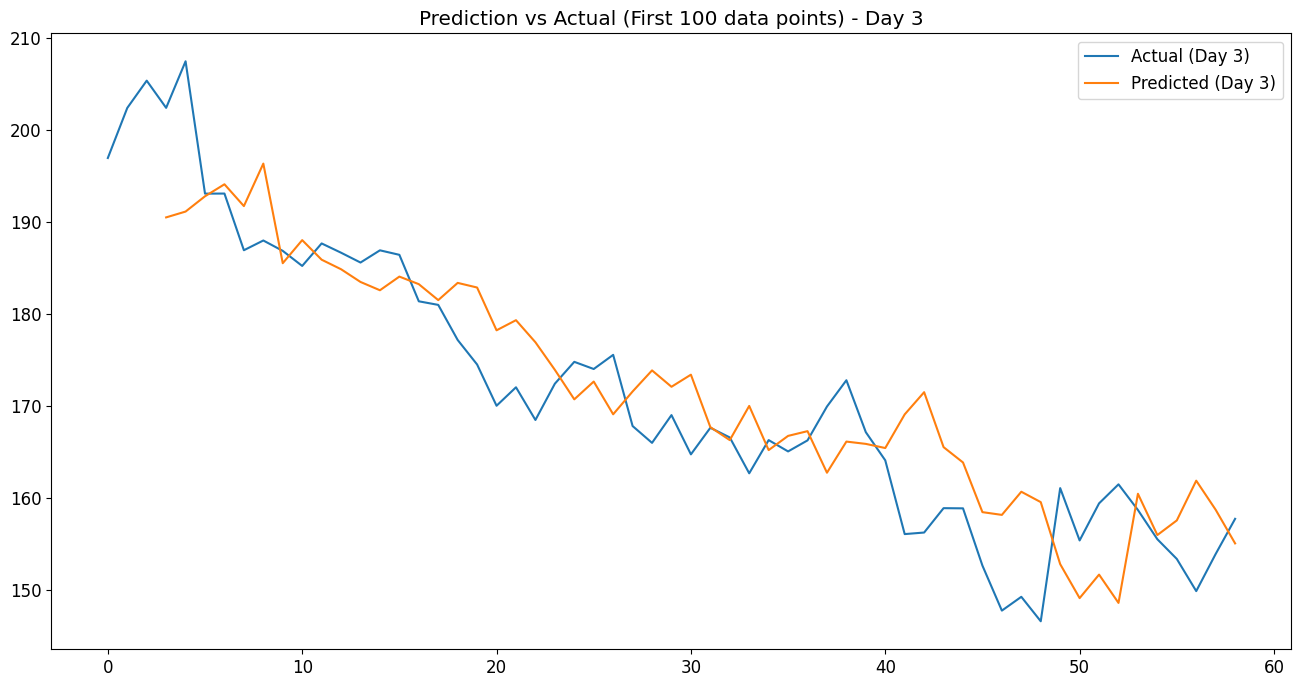

In [ ]:
import matplotlib.pyplot as plt

# Example: Visualize predictions vs actual values (for the first few data points)

for day in range(output_len):
    # Take the first 100 predictions for visualization
    plt.figure(figsize=(16, 8))
    plt.plot(results_df['Truth'], label=f'Actual (Day {day+1})')
    plt.plot(results_df.iloc[:, day +2], label=f'Predicted (Day {day+1})')
    plt.legend()
    plt.title(f'Prediction vs Actual (First 100 data points) - Day {day+1}')
    plt.show()


In [ ]:
test_df = pd.DataFrame(columns=['Date', 'Truth'])
test_df["Date"] = data[test_start_index:].index
test_df["Truth"] = data[test_start_index:].values

IntSlider(value=16, description='Date Index:', max=58, min=10)

IntText(value=0, description='Start Crop:')

IntText(value=71, description='End Crop:')

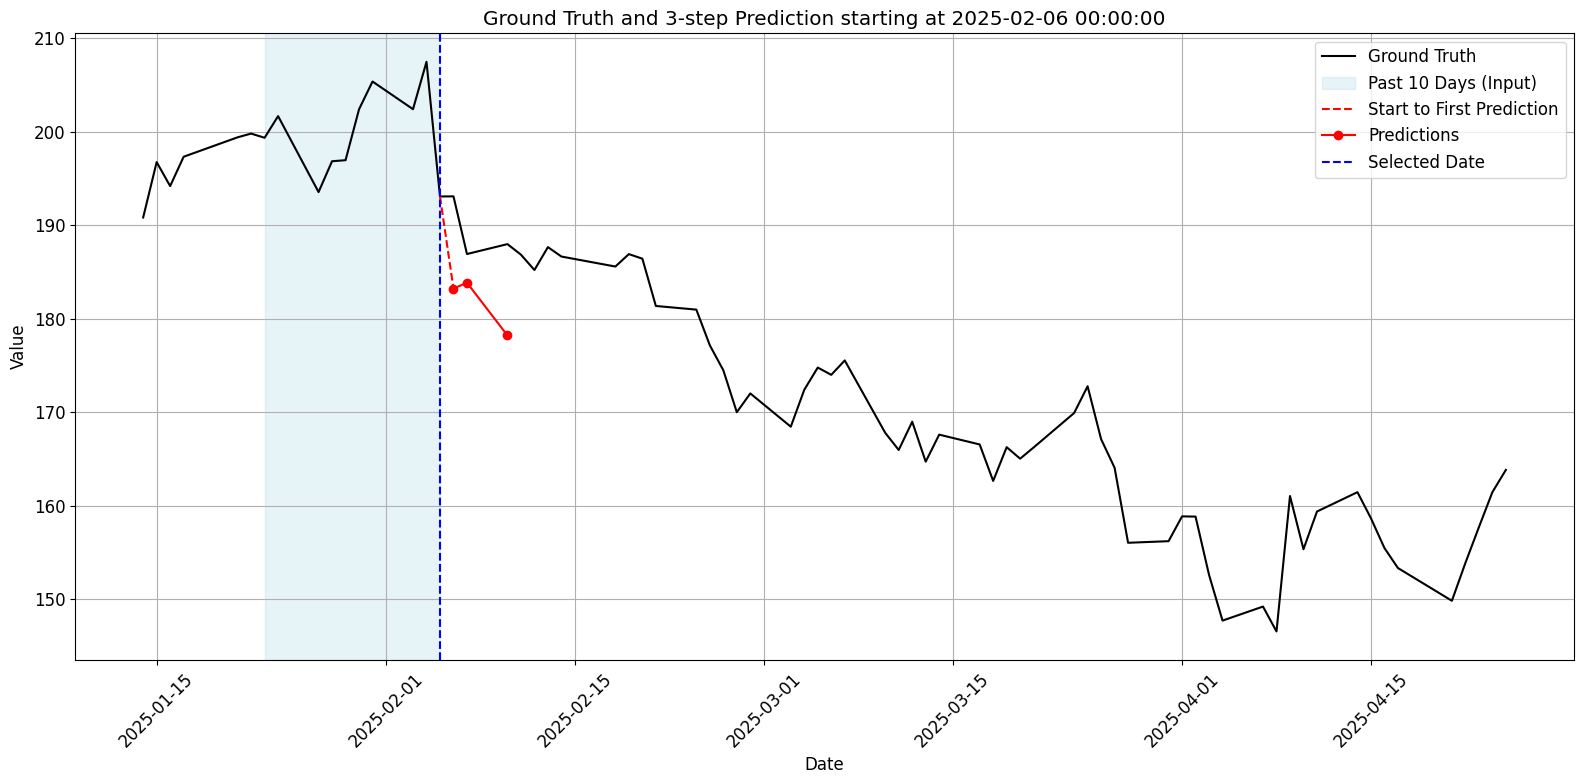

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget setup
date_slider = widgets.IntSlider(
    min=past_window,
    max=len(results_df) - 1,
    step=1,
    value=past_window,
    description='Date Index:'
)

start_crop = widgets.IntText(value=0, description='Start Crop:')
end_crop = widgets.IntText(value=len(test_df), description='End Crop:')

# Function to update the plot
def update_plot(change):
    date_index = date_slider.value
    start = start_crop.value
    end = end_crop.value
    end = min(end, len(test_df))
    start = min(start, end - 1)

    clear_output(wait=True)
    display(date_slider, start_crop, end_crop)

    plt.figure(figsize=(16, 8))

    # Plot the full ground truth using test_df
    plt.plot(test_df['Date'][start:end], test_df['Truth'][start:end], label='Ground Truth', color='black')

    # Highlight the past window used for prediction
    if date_index - past_window >= 0:
        plt.axvspan(
            test_df['Date'].iloc[date_index-past_window],
            test_df['Date'].iloc[date_index-1],
            color='lightblue',
            alpha=0.3,
            label=f'Past {past_window} Days (Input)'
        )

    # Plot prediction points starting from the selected date
    if date_index + output_len <= len(results_df) and date_index - 1 >= 0:
        # Prediction points (adjusted for output_len)
        pred_x = [test_df['Date'].iloc[date_index + i] for i in range(output_len)]
        pred_y = [results_df.loc[date_index + i, f'Prediction_{output_len-i}_Days_Ago'] for i in range(output_len)]

        # Connect true value at (date_index-1) to first prediction
        true_value = test_df['Truth'].iloc[date_index - 1]
        connection_x = [test_df['Date'].iloc[date_index - 1], test_df['Date'].iloc[date_index]]
        connection_y = [true_value, pred_y[0]]

        plt.plot(connection_x, connection_y, color='red', linestyle='--', label='Start to First Prediction')

        # Connect prediction points
        plt.plot(pred_x, pred_y, color='red', marker='o', label='Predictions', zorder=5)

    plt.axvline(x=test_df['Date'].iloc[date_index-1], color='blue', linestyle='--', label='Selected Date')
    plt.legend()
    plt.title(f'Ground Truth and {output_len}-step Prediction starting at {test_df["Date"].iloc[date_index]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Observe changes
date_slider.observe(update_plot, names='value')
start_crop.observe(update_plot, names='value')
end_crop.observe(update_plot, names='value')

# Display widgets initially
display(date_slider, start_crop, end_crop)

# Initial call
update_plot(None)


## Evaluation (only for more than 3-day predictions)

In [ ]:
results_df

,Date,Truth,Prediction_1_Days_Ago,Prediction_2_Days_Ago,Prediction_3_Days_Ago
0,2025-01-29,196.955612,NaN,NaN,NaN
1,2025-01-30,202.399414,190.48454,NaN,NaN
2,2025-01-31,205.366043,191.16226,191.00370,NaN
3,2025-02-03,202.409393,192.86696,191.67004,190.49796
4,2025-02-04,207.473633,194.19453,193.36910,191.13167
5,2025-02-05,193.080032,191.82271,194.69534,192.79436
6,2025-02-06,193.090012,196.42050,192.31218,194.09820
7,2025-02-07,186.927032,185.58092,196.93999,191.72656
8,2025-02-10,187.985825,187.97408,186.05050,196.34738
9,2025-02-11,186.857132,185.84620,188.49374,185.51650


In [ ]:
# Create a new dataframe
new_df = pd.DataFrame()
new_df['Date'] = results_df['Date']
new_df['Truth'] = results_df['Truth']

# Add new future-facing predictions
new_df['Prediction_1_Day_Ahead'] = results_df['Prediction_1_Days_Ago'].shift(-1)
new_df['Prediction_2_Days_Ahead'] = results_df['Prediction_2_Days_Ago'].shift(-2)
new_df['Prediction_3_Days_Ahead'] = results_df['Prediction_3_Days_Ago'].shift(-3)

# Drop rows with NaNs at the end (optional, depending on your case)
new_df = new_df.dropna()

new_df.head()

,Date,Truth,Prediction_1_Day_Ahead,Prediction_2_Days_Ahead,Prediction_3_Days_Ahead
0,2025-01-29,196.955612,190.48454,191.00370,190.49796
1,2025-01-30,202.399414,191.16226,191.67004,191.13167
2,2025-01-31,205.366043,192.86696,193.36910,192.79436
3,2025-02-03,202.409393,194.19453,194.69534,194.09820
4,2025-02-04,207.473633,191.82271,192.31218,191.72656


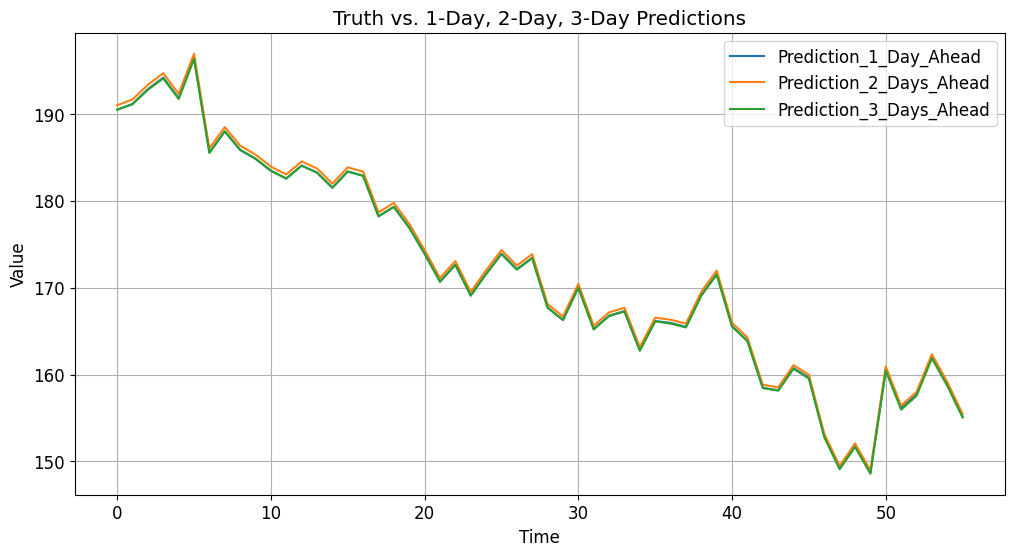

In [ ]:
pred_df = new_df.drop(['Date'], axis=1, errors='ignore').copy()
pred_df.dropna()
# Select prediction columns (all except 'Truth' and 'Date')
pred_cols = [col for col in pred_df.columns if col not in ['Truth', 'Date']]
pred_df = pred_df[pred_cols]  # Subset DataFrame

# Calculate the errors for each day
errors = new_df['Truth'].values[:, None] - pred_df.values # Convert to NumPy arrays for subtraction

# Plot the truth vs predictions for each day
plt.figure(figsize=(12, 6))
# plt.plot(results_df['Truth'], label='Truth')

for i in range(len(pred_cols)):
    plt.plot(new_df[pred_cols[i]], label=f'{pred_cols[i]}')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Truth vs. 1-Day, 2-Day, 3-Day Predictions")
plt.grid(True)
plt.show()


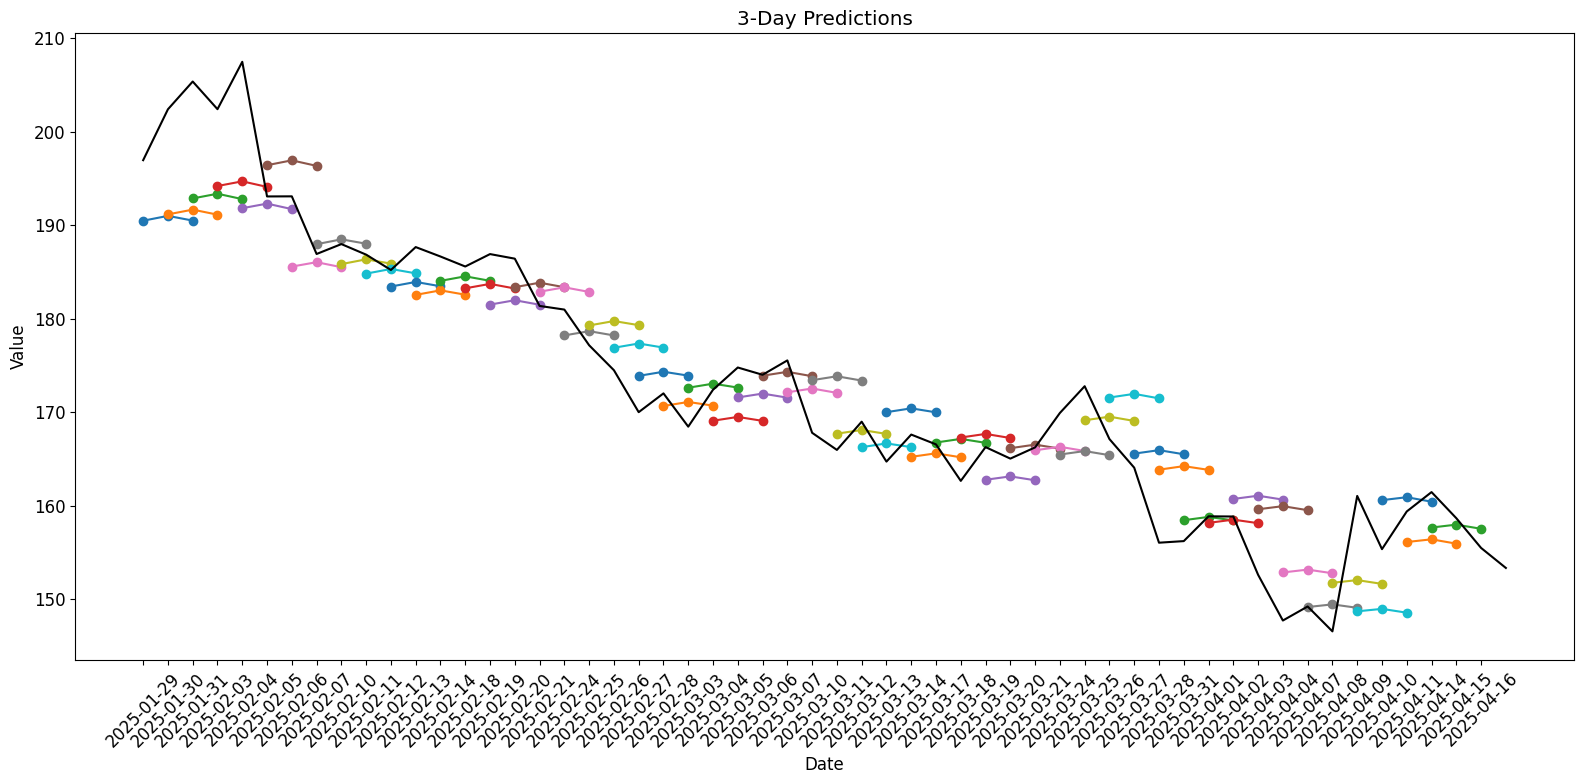

In [ ]:
# Plotting all 3-day predictions
plt.figure(figsize=(16, 8))

for i in range(len(new_df)-3):
    # Get predictions and truth for this sequence
    predictions = [
        new_df.loc[i, 'Prediction_1_Day_Ahead'],
        new_df.loc[i, 'Prediction_2_Days_Ahead'] if i < len(new_df) else None,
        new_df.loc[i, 'Prediction_3_Days_Ahead'] if i < len(new_df) else None,
    ]
    truth = new_df.loc[i, 'Truth']

    # Only plot if there are 3 predictions
    if None not in predictions:
        dates = [new_df.loc[i, 'Date'], new_df.loc[i + 1, 'Date'], new_df.loc[i + 2, 'Date']]
        plt.plot(dates, predictions, marker='o', linestyle='-')

plt.plot(new_df['Truth'], color='black', label='Truth')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('3-Day Predictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
results_df = pd.read_csv('predictions_with_lags_test.csv')
results_df.head(10)

,Date,Truth,Prediction_1_Days_Ago,Prediction_2_Days_Ago,Prediction_3_Days_Ago
0,2025-01-29,196.955612,NaN,NaN,NaN
1,2025-01-30,202.399414,190.48454,NaN,NaN
2,2025-01-31,205.366043,191.16226,191.00370,NaN
3,2025-02-03,202.409393,192.86696,191.67004,190.49796
4,2025-02-04,207.473633,194.19453,193.36910,191.13167
5,2025-02-05,193.080032,191.82271,194.69534,192.79436
6,2025-02-06,193.090012,196.42050,192.31218,194.09820
7,2025-02-07,186.927032,185.58092,196.93999,191.72656
8,2025-02-10,187.985825,187.97408,186.05050,196.34738
9,2025-02-11,186.857132,185.84620,188.49374,185.51650


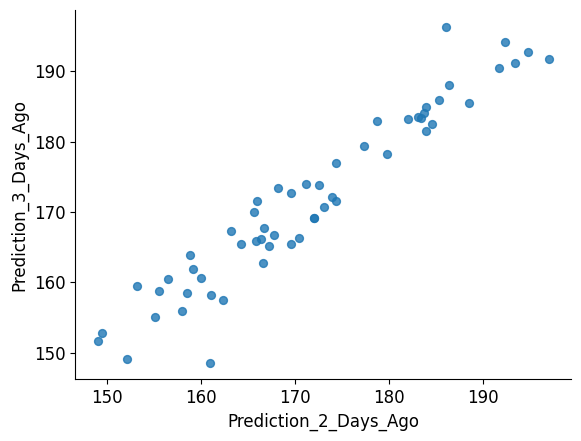

In [ ]:
# @title Prediction_2_Days_Ago vs Prediction_3_Days_Ago

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Prediction_2_Days_Ago', y='Prediction_3_Days_Ago', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

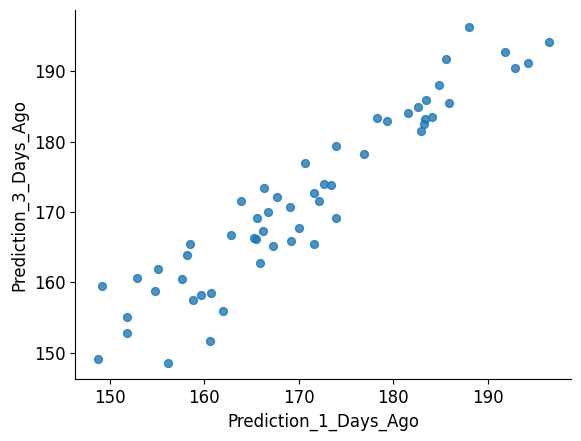

In [ ]:
from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Prediction_1_Days_Ago', y='Prediction_3_Days_Ago', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

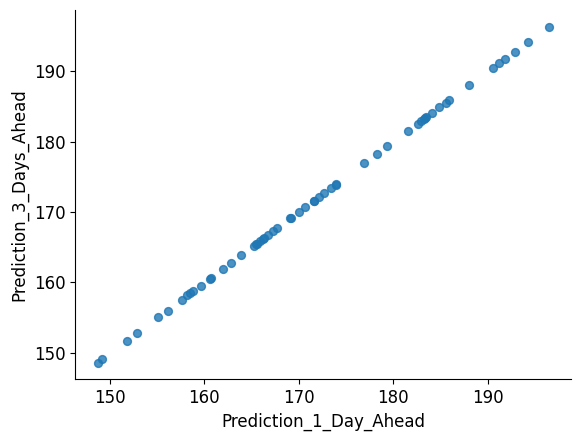

In [ ]:
from matplotlib import pyplot as plt
new_df.plot(kind='scatter', x='Prediction_1_Day_Ahead', y='Prediction_3_Days_Ahead', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

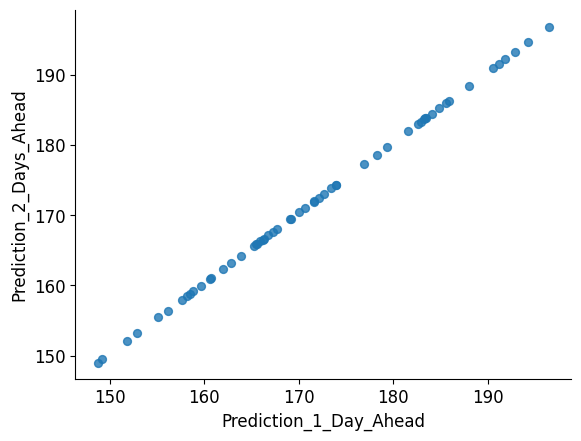

In [ ]:
from matplotlib import pyplot as plt
new_df.plot(kind='scatter', x='Prediction_1_Day_Ahead', y='Prediction_2_Days_Ahead', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

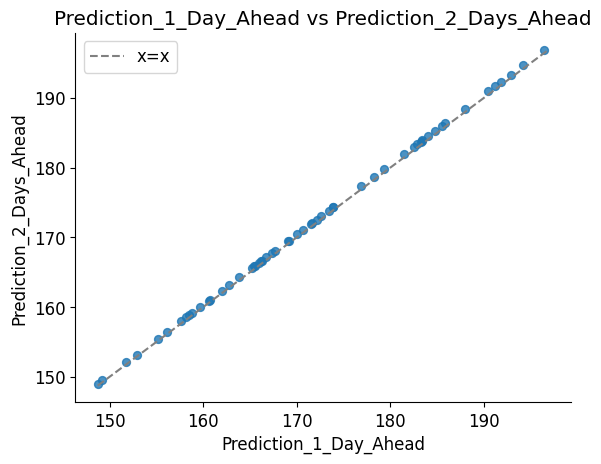

In [ ]:
# @title Prediction_1_Days_Ago vs Prediction_2_Days_Ago

from matplotlib import pyplot as plt
import numpy as np  # Import numpy if not already imported

# Create the scatter plot
new_df.plot(kind='scatter', x='Prediction_1_Day_Ahead', y='Prediction_2_Days_Ahead', s=32, alpha=.8)

# Add x=x line
# Get the range of values for the x=x line
min_val = min(new_df['Prediction_1_Day_Ahead'].min(), new_df['Prediction_2_Days_Ahead'].min())
max_val = max(new_df['Prediction_1_Day_Ahead'].max(), new_df['Prediction_2_Days_Ahead'].max())

# Create the line data
x = np.linspace(min_val, max_val, 100)  # Create 100 points between min and max
y = x  # x=x line

# Plot the line
plt.plot(x, y, linestyle='--', color='gray', label='x=x')

# Customize the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()  # Show the legend
plt.title("Prediction_1_Day_Ahead vs Prediction_2_Days_Ahead")  # Add a title
plt.xlabel("Prediction_1_Day_Ahead")
plt.ylabel("Prediction_2_Days_Ahead")
plt.show()

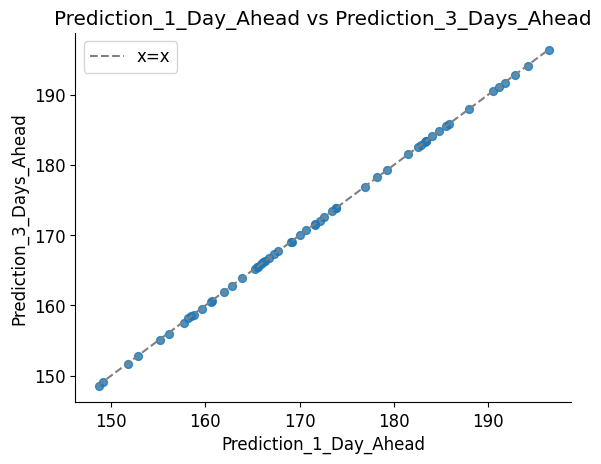

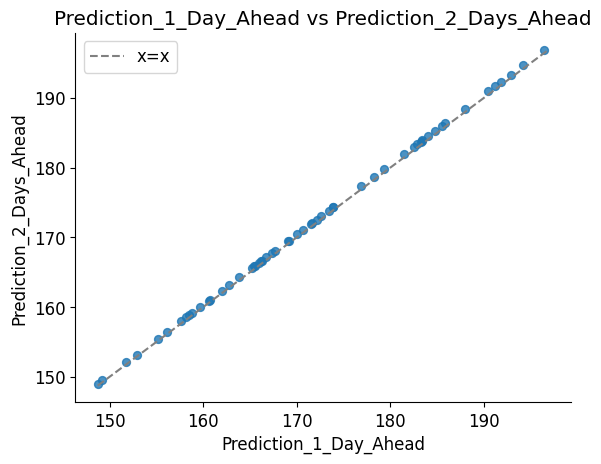

In [ ]:
# @title Prediction_1_Days_Ago vs Prediction_2_Days_Ago

from matplotlib import pyplot as plt
import numpy as np  # Import numpy if not already imported

# Create the scatter plot
new_df.plot(kind='scatter', x='Prediction_1_Day_Ahead', y='Prediction_3_Days_Ahead', s=32, alpha=.8)

# Add x=x line
# Get the range of values for the x=x line
min_val = min(new_df['Prediction_1_Day_Ahead'].min(), new_df['Prediction_3_Days_Ahead'].min())
max_val = max(new_df['Prediction_1_Day_Ahead'].max(), new_df['Prediction_3_Days_Ahead'].max())

# Create the line data
x = np.linspace(min_val, max_val, 100)  # Create 100 points between min and max
y = x  # x=x line

# Plot the line
plt.plot(x, y, linestyle='--', color='gray', label='x=x')

# Customize the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()  # Show the legend
plt.title("Prediction_1_Day_Ahead vs Prediction_3_Days_Ahead")  # Add a title
plt.xlabel("Prediction_1_Day_Ahead")
plt.ylabel("Prediction_3_Days_Ahead")
plt.show()

# @title Prediction_1_Days_Ago vs Prediction_2_Days_Ago

from matplotlib import pyplot as plt
import numpy as np  # Import numpy if not already imported

# Create the scatter plot
new_df.plot(kind='scatter', x='Prediction_1_Day_Ahead', y='Prediction_2_Days_Ahead', s=32, alpha=.8)

# Add x=x line
# Get the range of values for the x=x line
min_val = min(new_df['Prediction_1_Day_Ahead'].min(), new_df['Prediction_2_Days_Ahead'].min())
max_val = max(new_df['Prediction_1_Day_Ahead'].max(), new_df['Prediction_2_Days_Ahead'].max())

# Create the line data
x = np.linspace(min_val, max_val, 100)  # Create 100 points between min and max
y = x  # x=x line

# Plot the line
plt.plot(x, y, linestyle='--', color='gray', label='x=x')

# Customize the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()  # Show the legend
plt.title("Prediction_1_Day_Ahead vs Prediction_2_Days_Ahead")  # Add a title
plt.xlabel("Prediction_1_Day_Ahead")
plt.ylabel("Prediction_2_Days_Ahead")
plt.show()

### 3D plot

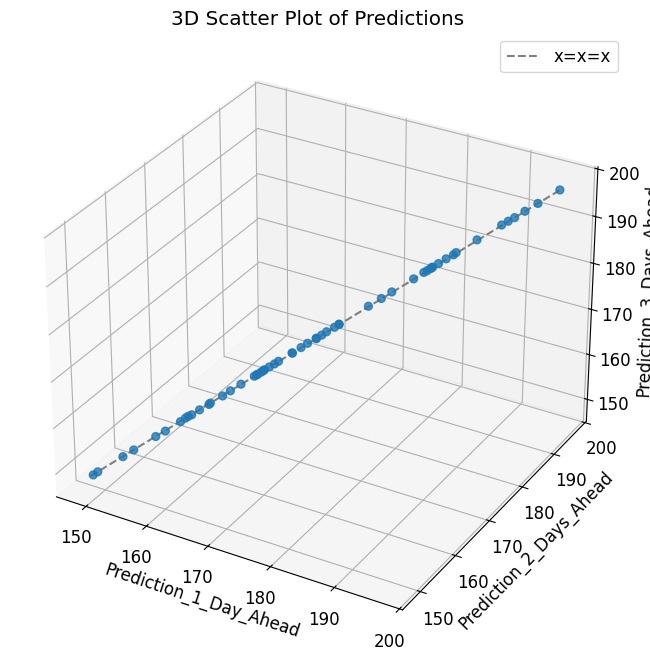

In [ ]:
# @title Prediction_1_Days_Ago vs Prediction_2_Days_Ago vs Prediction_3_Days_Ago

from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Create the figure and axes object for the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot data
x = new_df['Prediction_1_Day_Ahead']
y = new_df['Prediction_2_Days_Ahead']
z = new_df['Prediction_3_Days_Ahead']

ax.scatter(x, y, z, s=32, alpha=.8)

# Add x=x=x line (diagonal in 3D)
min_val = min(x.min(), y.min(), z.min())
max_val = max(x.max(), y.max(), z.max())
line_data = np.linspace(min_val, max_val, 100)
ax.plot(line_data, line_data, line_data, linestyle='--', color='gray', label='x=x=x')

# Customize the plot
ax.set_xlabel("Prediction_1_Day_Ahead")
ax.set_ylabel("Prediction_2_Days_Ahead")
ax.set_zlabel("Prediction_3_Days_Ahead")
ax.set_title("3D Scatter Plot of Predictions")
ax.legend()

plt.show()

In [ ]:
!pip install plotly -q

import plotly.graph_objects as go
import numpy as np

# Scatter plot data
x = new_df['Prediction_1_Day_Ahead']
y = new_df['Prediction_2_Days_Ahead']
z = new_df['Prediction_3_Days_Ahead']

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Add x=x=x line (diagonal in 3D)
min_val = min(x.min(), y.min(), z.min())
max_val = max(x.max(), y.max(), z.max())
line_data = np.linspace(min_val, max_val, 100)
fig.add_trace(go.Scatter3d(
    x=line_data,
    y=line_data,
    z=line_data,
    mode='lines',
    line=dict(color='gray', width=2, dash='dash'),
    name='x=x=x'
))

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title="Prediction_1_Day_Ahead",
        yaxis_title="Prediction_2_Days_Ahead",
        zaxis_title="Prediction_3_Days_Ahead"
    ),
    title="Interactive 3D Scatter Plot of Predictions"
)

fig.show()

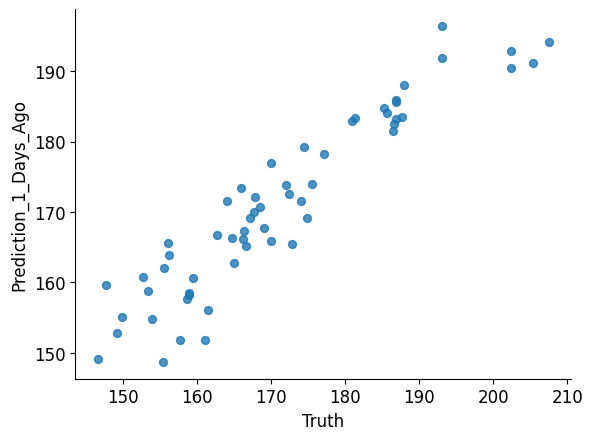

In [ ]:
# @title Truth vs Prediction_1_Days_Ago

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Truth', y='Prediction_1_Days_Ago', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Documentation - generate images, tables